In [1]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


# Imports

In [2]:
import math
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Constants

In [3]:
r2d = 180./math.pi
d2r = math.pi/180.
Re = 6371000. # meters
c = 299792458. # m/s

# Functions

In [4]:
def geodetic_to_ECEF_spherical(lat, lon, height):
    X = (Re+height)*math.cos(lat)*math.cos(lon)
    Y = (Re+height)*math.cos(lat)*math.sin(lon)
    Z = (Re+height)*math.sin(lat)

    return np.matrix([[X],[Y],[Z]])

In [5]:
def ECEF_to_geodetic_spherical(X,Y,Z):
    H = math.hypot(X, Y)
    lat = math.atan2(Z,H)
    lon = math.atan2(Y,X)
    height = math.sqrt(X*X + Y*Y + Z*Z) - Re

    return {'lat':lat,'lon':lon,'height':height}

In [6]:
## CNE - ECEF to NED transform matrix
def getCNE(lat, lon):
    sL = math.sin(lon)
    cL = math.cos(lon)
    sP = math.sin(lat)
    cP = math.cos(lat)

    return np.matrix([[-cL*sP, -sL*sP, cP],
                     [-sL, cL, 0],
                     [-cL*cP, -sL*cP, -sP]])

In [7]:
## CEN - NED to ECEF transform matrix
def getCEN(lat,lon):
    sL = math.sin(lon)
    cL = math.cos(lon)
    sP = math.sin(lat)
    cP = math.cos(lat)

    return np.matrix([[-cL*sP, -sL, -cL*cP],
                     [-sL*sP, cL, -sL*cP],
                     [cP, 0, -sP]])

# Problem 1-1

**(a)** How many decimal places are required to express 1 centimeter in degrees?  
**(b)** How many decimal places are required to express 1 centimeter in arc seconds?  
**(c)** *(Not in book)* How many decimal places are required to express 1 kilometer in degrees?  

The following unit conversion relationships are useful:
* 1 arc minute latitude = 1852 meters
* 1 arc degree latitude = 60 arc minutes
* 1 arc minute latitude = 60 arc seconds

## Solutions

### (a)

In [8]:
def problem_1_1_a():

    ref_len_cm = 1
    lat_deg_per_meters = 1/1852/60
    
    cm_deg = ref_len_cm/100*lat_deg_per_meters
    numdigits = int(math.ceil(-math.log10(cm_deg)))
    
    print("\t{0:d} cm = {1:15.12f} deg latitude".format(ref_len_cm, cm_deg))
    print("\t{0:d} decimal places required for {1:d} cm precision in degrees latitude.\n".format(numdigits, ref_len_cm))
    
    return

problem_1_1_a()

	1 cm =  0.000000089993 deg latitude
	8 decimal places required for 1 cm precision in degrees latitude.



### (b)

In [9]:
def problem_1_1_b():

    ref_len_cm = 1
    lat_arcsec_per_meters = (1/1852)*60
    
    cm_arcsec = ref_len_cm/100*lat_arcsec_per_meters
    numdigits = int(math.ceil(-math.log10(cm_arcsec)))
    
    print("\t{0:d} cm = {1:15.12f} arc seconds latitude".format(ref_len_cm, cm_arcsec))
    print("\t{0:d} decimal places required for {1:d} cm precision in arc-seconds latitude.\n".format(numdigits, ref_len_cm))

problem_1_1_b()

	1 cm =  0.000323974082 arc seconds latitude
	4 decimal places required for 1 cm precision in arc-seconds latitude.



### (c)

In [10]:
def problem_1_1_c():
   
    ref_len_km = 1
    
    km_deg = ref_len_km*1000*1/1852/60
    numdigits = int(math.ceil(-math.log10(km_deg)))
    
    print("\t{0:d} km = {1:15.12f} deg latitude".format(ref_len_km, km_deg))
    print("\t{0:d} decimal places required for {1:d} km precision in degrees latitude.\n".format(numdigits, ref_len_km))

problem_1_1_c()

	1 km =  0.008999280058 deg latitude
	3 decimal places required for 1 km precision in degrees latitude.



# Problem 1-2
* Starting location latitude 45° N, longitude 120° W
* Constant height 10 km
* Ground speed 885 km/h
* Constant true heading 45°
* Assume spherical earth with radius 6371 km
* Fly for 8 hours
* Find final position

## Solution

In [11]:
def printDeltaLat(V,Re,psiT,T,lat0):
    lat_dot = V*math.cos(psiT)/Re
    delta_lat = lat_dot*T
    lat_final = lat0 + delta_lat
    print("Final latitude: {0:13.10f} deg N\n".format(lat_final*r2d))

In [12]:
## loop over the time vector
def rhumbLineSim(lat0, lon0, height, T, V, psiT):

    ## integration algorithm parameters

    dt = 0.1 # second

    ## 

    time_vec = np.linspace(0.0, T, num = math.floor(T/dt)+1, endpoint=False)

    lat = [lat0]
    lon = [lon0]

    velNED = np.matrix([[V*math.cos(psiT)], [V*math.sin(psiT)], [0]])
    CEN = getCEN(lat0, lon0)                      
    velECEF_last = CEN*velNED

    for i, t in enumerate(time_vec):
        posECEF = geodetic_to_ECEF_spherical(lat[i], lon[i], height)
        CEN = getCEN(lat[i], lon[i])
        velECEF = CEN*velNED

        # trapezoidal integration                  
        posECEF += 1/2 * (velECEF + velECEF_last)*dt

        velECEF_last = velECEF

        posGeodetic = ECEF_to_geodetic_spherical(posECEF[0], posECEF[1], posECEF[2])

        lat += [posGeodetic['lat']]
        lon += [posGeodetic['lon']]


    return (lat, lon)

In [13]:
def printLatLon(lat,lon):

    print("Start point:\n\t Lat: {0:8.5f} deg N, Lon:{1:8.5f} deg E".format(lat[0]*r2d, lon[0]*r2d))
    print("End point:\n\t Lat: {0:8.5f} deg N, Lon:{1:8.5f} deg E".format(lat[-1]*r2d, lon[-1]*r2d))

In [14]:
def plotTrajectory(lat,lon):

    lat_deg = [x*r2d for x in lat]
    lon_deg = [x*r2d for x in lon]

    fig = plt.figure(figsize=(20,10))

    # set up orthographic map projection with
    # perspective of satellite looking down at 55N, 100W.
    # use low resolution coastlines.
    m1 = Basemap(projection='ortho',lat_0=55,lon_0=-100,resolution=None)

    fig.add_axes([0.1,0.1,0.8,0.8])
    map = Basemap(projection='ortho',lat_0=55,lon_0=-100,resolution='l', \
        llcrnrx=-m1.urcrnrx/2.,llcrnry=-m1.urcrnry/4,urcrnrx=m1.urcrnrx/2.,urcrnry=m1.urcrnry/2.)
    # draw coastlines, country boundaries, fill continents.
    map.drawcoastlines(linewidth=0.25)
    map.drawcountries(linewidth=0.25)
    map.fillcontinents(color='0.75',lake_color='#ccddff')
    # draw the edge of the map projection region (the projection limb)
    map.drawmapboundary(fill_color='#ccddff')
    # draw lat/lon grid lines every 30 degrees.
    map.drawmeridians(np.arange(0,360,30))
    map.drawparallels(np.arange(-90,90,30))

    # project the trajectory data onto the map
    xx, yy = map(lon_deg,lat_deg)
    map.plot(xx,yy,linewidth=3,color='r')

    plt.title('Trajectory Visualization')
    plt.show()

Final latitude: 90.0228815457 deg N

Start point:
	 Lat: 45.00000 deg N, Lon:-120.00000 deg E
End point:
	 Lat: 89.95143 deg N, Lon:-85.16541 deg E


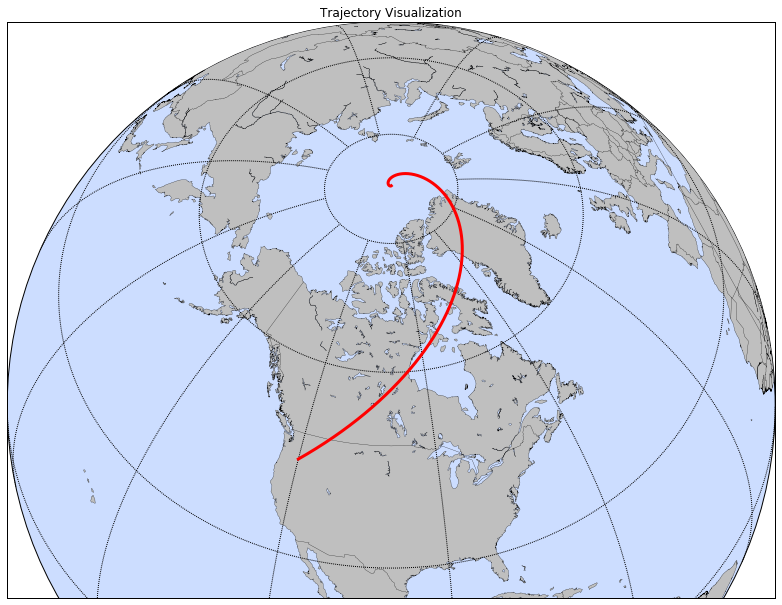

In [15]:
def problem_1_2():
    
    ## problem parameters
    
    lat0_deg = 45.   # deg north initial latitude
    lon0_deg = -120. # deg east initial longitude
    height_km = 10. # kilometers altitude
    V_kmph = 885. # km/hr flight speed
    psiT_deg = 45. # deg true heading    
    T_hr = 8. # hours flight duration
    
    ## derived quantities (consistent units)
    
    lat0 = lat0_deg*d2r # radians
    lon0 = lon0_deg*d2r # radians
    height = height_km*1000. # meters
    V = V_kmph*1000./3600. # meters per second
    psiT = psiT_deg*d2r # radians
    T = T_hr*3600. # seconds

    ## 

    printDeltaLat(V,Re,psiT,T,lat0)    
    lat, lon = rhumbLineSim(lat0, lon0, height, T, V, psiT)
    printLatLon(lat,lon)           
    plotTrajectory(lat,lon)
    
problem_1_2()

# Problem 1-3
* Aircraft broadcasting tone at 100 MHz
* Flying away in straight line at constant altitude
* Ground speed 360 km/h
* 3 measurements 0.1 sec apart:
    * -33.1679 Hz
    * -33.1711 Hz
    * -33.1743 Hz

Determine the following:  
**(a)** Determine the range rates in m/s for each measurement  
**(b)** Find two linear equations that relate $x_1$ and $x_2$ to $x_0$  
**(c)** Set up two nonlinear equations to relate $x_0$ and $y_0$ to the measurements and solve iteratively

Geometry and signal characteristics
\begin{align}
    r_i &= \sqrt{x_i^2 + y_0^2} \\
    \dot{r}_i &= \frac{V\,x_i}{r_i} \\
    \lambda &= \frac{c}{f} \\
    \Delta f_\text{dop} &= -\frac{\dot{r}}{\lambda} = -\frac{V x_i}{c r_i} f
\end{align}

## Solution

### (a)

\begin{align}
    \dot{r} = -\lambda \Delta f_\text{dop}
\end{align}

In [16]:
def problem_1_3_a():

    f_MHz = 100. # MHz, aircraft transmitter carrier frequency
    V_kmph = 360. # km/h
    dt = 0.1 # sec

    ##

    f = f_MHz*10.**6; # Hz
    V = V_kmph*1000/3600 # m/s    
    dop_Hz = np.array([-33.1679, -33.1711, -33.1743])

    lam = c/f

    rdot = - lam*dop_Hz

    print("\trdot_0 = {0:6.3f} m/s".format(rdot[0]))
    print("\trdot_1 = {0:6.3f} m/s".format(rdot[1]))
    print("\trdot_2 = {0:6.3f} m/s".format(rdot[2]))

problem_1_3_a()

	rdot_0 = 99.435 m/s
	rdot_1 = 99.444 m/s
	rdot_2 = 99.454 m/s


### (b)

Linear position dependence
\begin{align}
    x_1 &= x_0 + \Delta t \, V \\
    x_2 &= x_0 + 2 \Delta t \, V     
\end{align}

### (c)

Residual calculation
\begin{align}
    z_0 &= -\frac{V x_0}{c \sqrt{x_0^2 + y_0^2}} f  - \Delta f_{\text{dop}_0} \\
    z_1 &= -\frac{V (x_0 + \Delta t \, V)}{c \sqrt{(x_0 + \Delta t \, V)^2 + y_0^2}} f - \Delta f_{\text{dop}_1} \\
    z_2 &= -\frac{V (x_0 + 2 \Delta t \, V)}{c \sqrt{(x_0 + 2\Delta t \, V)^2 + y_0^2}} f - \Delta f_{\text{dop}_2} \\
\end{align}

Objective function
\begin{equation}
    F = z_0^2 + z_1^2 + z_2^2
\end{equation}

In [17]:
def rangeRate(x, y0, V):
    return V*np.divide(x,np.sqrt(np.multiply(x, x) + y0*y0))

In [18]:
def dopEst(x, y0, V, lam):
    return -rangeRate(x,y0,V)/lam

In [19]:
def calcResidual(x0, y0, V, lam, dt, dop_Hz):
    x = np.array([x0,x0+V*dt,x0+2*V*dt])
    return dopEst(x,y0,V,lam) - dop_Hz

In [20]:
def f_obj(xx, V, lam, dt, dop_Hz):
    res = calcResidual(xx[0], xx[1], V, lam, dt, dop_Hz)
    return np.dot(res,res)

In [21]:
def problem_1_3_c():

    f_MHz = 100. # MHz, aircraft transmitter carrier frequency
    V_kmph = 360. # km/h
    dt = 0.1 # sec
    
    ##
    
    f = f_MHz*10.**6; # Hz
    V = V_kmph*1000/3600 # m/s    
    dop_Hz = np.array([-33.1679, -33.1711, -33.1743])
    
    lam = c/f
   
    x0 = np.array([100,100])
        
    res = minimize(lambda x: f_obj(x, V, lam, dt, dop_Hz), x0, method='nelder-mead',
        options={'xtol': 1e-9, 'disp': True})
            
    residual = calcResidual(res.x[0], res.x[1], V, lam, dt, dop_Hz)
    
    print("\n", res, "\n")

    print("Final residuals:\n")
    
    print("\t", residual[0])
    print("\t", residual[1])
    print("\t", residual[2])

    print("\nX0 = {0:6.1f} meters\nY0 = {1:6.1f} meters\n".format(res.x[0], res.x[1]))
    
problem_1_3_c()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 124
         Function evaluations: 261

   status: 0
     nit: 124
    nfev: 261
 message: 'Optimization terminated successfully.'
       x: array([ 1138.67925342,   121.57824021])
     fun: 1.138401453317609e-09
 success: True 

Final residuals:

	 1.34190460557e-05
	 -2.75436669668e-05
	 1.41307135806e-05

X0 = 1138.7 meters
Y0 =  121.6 meters



# Problem 1-4

* An observer is on a line between pseudolites PL1 and PL2
* PL1 and PL2 are separated by 1 km
* The pseudolite clocks are perfectly synchronized
* The observer's clock has a bias with respect to the pseudolite clocks
* Estimate the observer's position and clock bias


**(a)** Pseudoranges are $\rho_1 = 550$ m and $\rho_2 = 500$ m  

**(b)** Pseudoranges are $\rho_1 = 400$ m and $\rho_2 = 1400$ m

## Solutions

\begin{align}
    \big|\,x_{PL1} - x\,\big| = \rho_1 - t\\
    \big|\,x_{PL2} - x\,\big| = \rho_2 - t
\end{align}

Solve for $t$ as
\begin{align}
    t = \rho_1 - \big|\,x_{PL1} - x\,\big| \\
    t = \rho_2 - \big|\,x_{PL2} - x\,\big|
\end{align}
and then substitute
\begin{equation}
     \rho_1 - \rho_2 =  \big|\,x_{PL1} - x\,\big| - \big|\,x_{PL2} - x\,\big|
\end{equation}
which reduces to two cases:
\begin{equation}
      x = \frac{1}{2} \left(x_{PL1}+ x_{PL2} - \rho_1 + \rho_2 \right)
\end{equation}
or
\begin{equation}
      x = \frac{1}{2} \left( x_{PL1} + x_{PL2} + \rho_1 - \rho_2  \right)
\end{equation}

### (a)

\begin{align}
     x &= \frac{1}{2} \left(x_{PL1}+ x_{PL2} - \rho_1 + \rho_2 \right) \\
      &=  \frac{1}{2} \left(1000 - 550 + 500 \right) \\
      &= 475~\text{m}
\end{align}
or
\begin{align}
     x &= \frac{1}{2} \left(x_{PL1}+ x_{PL2} + \rho_1 - \rho_2 \right) \\
      &=  \frac{1}{2} \left(1000 + 550 - 500 \right) \\
      &= 525~\text{m}
\end{align}

Check for consistency with $t$
\begin{align}
    t &= 550 - \big|\,0 - 475\,\big| &= 75~\text{m} \\
    t &= 500 - \big|\,1000 - 475\,\big| &= -25~\text{m} \\
\end{align}
or
\begin{align}
    t &= 550 - \big|\,0 - 525\,\big| &= 25~\text{m} \\
    t &= 500 - \big|\,1000 - 525\,\big| &= 25~\text{m} \\
\end{align}

Therefore $x = 525$ m is the position of the observer and the clock bias is $25$ m.


### (b)

\begin{align}
     x &= \frac{1}{2} \left(x_{PL1}+ x_{PL2} - \rho_1 + \rho_2 \right) \\
      &=  \frac{1}{2} \left(1000 - 400 + 1400 \right) \\
      &= 1000~m
\end{align}
or
\begin{align}
     x &= \frac{1}{2} \left(x_{PL1}+ x_{PL2} + \rho_1 - \rho_2 \right) \\
      &=  \frac{1}{2} \left(1000 + 400 - 1400 \right) \\
      &= 0~m
\end{align}

Check for consistency with $t$
\begin{align}
    t &= 400 - \big|\,0 - 1000\,\big| &= -600~\text{m} \\
    t &= 1400 - \big|\,1000 - 1000\,\big| &= 1400~\text{m} \\
\end{align}
or
\begin{align}
    t &= 400 - \big|\,0 - 0\,\big| &= 400~\text{m} \\
    t &= 1400 - \big|\,1000 - 0\,\big| &= 400~\text{m} \\
\end{align}

Therefore $x = 0$ m is the position of the observer and the clock bias is $400$ m.


# Problem 1-5

* Town B is 120 km east of Town A
* Vehicle odometer accuracy is 1-2 km error for 50 km traveled
* Watch is accurate for time intervals but has an absolute bias

**(a)** Stopped with odometer reading 56 km.  Estimate your position.  

**(b)** Red bus passes at 21 minutes past the hour observed on watch having left Town A exactly on the hour and traveling exactly 3 km/min. Estimate your position.  

**(c)** Estimate position and clock bias from available information so far.  Write two equations relating estimates to known information.  

**(d)** Blue bus passes at 25 minutes past the hour observed on watch having left Town B exactly on the hour and traveling exactly 2.5 km/min. Again estimate position and clock bias with all available information.  

**(e)** How would the solution be affected if the watch were running 5 minutes faster and the clocks in Town A and Town B were running 5 minutes fast.  

**(f)** Suppose odometer does not work and only yellow cabs from carrier L1 pass.  L1 cabs leave Town A every minute on the minute and travel to Town B at 1 km/min.  Can you estimate position and clock error?  Would it help if green cabs from L2 leave Town B every minute on the minute and travel 1 km/min toward Town A?  Explain.

## Solutions

### (a)

\begin{align}
    \hat{x} = 56~\text{km} \pm 2~\text{km from Town A}
\end{align}

### (b)

\begin{align}
    \hat{x} = 21~\text{min} \cdot 3~\text{km/min} = 63~\text{km from Town A}
\end{align}

### (c)

Let $V_R$ be the red bus speed, $x_o$ be the odometer measurement, 
$b_o$ be the odometer bias, $t_A$ be the observer clock measurment
when the red bus passes, 
and $b_c$ be the observer clock bias.  Then
\begin{align}
    \hat{x} &= x_o - b_o \\
    \hat{x} &= (t_A - b_c) V_R
\end{align}
We have two equations and 3 unknowns: $\hat{x},~b_o,~\text{and}~b_c$.

### (d)

Let $V_B$ be the blue bus speed, $t_B$ be the observer clock measurement when the blue bus passes, and $L$ be the distance from Town A to Town B.  Then,
\begin{align}
    \hat{x} &= x_o - b_o \\
    \hat{x} &= (t_A - b_c) V_R \\
    \hat{x} &= L - (t_B - b_c) V_B
\end{align}  

We now have suffucient information to solve for unknowns $\hat{x},~b_o,~\text{and}~b_c$.  Rewriting the above equations in matrix form we have  
\begin{align}
    \begin{bmatrix}
        1 & 1 & 0 \\
        1 & 0 & V_R \\
        1 & 0 & -V_B
    \end{bmatrix}
    \begin{bmatrix}
        \hat{x} \\ b_o \\ b_c
    \end{bmatrix}
    =
    \begin{bmatrix}
        x_o \\
        t_A V_R \\
        L - t_B V_B
    \end{bmatrix}
\end{align}

In [22]:
x_o = 56
V_R = 3
V_B = 2.5
L = 120
t_A = 21
t_B = 25
H = np.matrix([[1, 1, 0], [1, 0, V_R], [1, 0, -V_B]])
B = np.matrix([[x_o], [t_A*V_R],[L - t_B*V_B]])
X = np.linalg.pinv(H)*B

print("Position estimate xhat             = {0:5.1f} km".format(X[0,0]))
print("Odometer bias estimate b_o         = {0:5.1f} km".format(X[1,0]))
print("Observer clock bias estimate b_c   = {0:5.1f} km".format(X[2,0]))

Position estimate xhat             =  60.0 km
Odometer bias estimate b_o         =  -4.0 km
Observer clock bias estimate b_c   =   1.0 km


### (e)

Changing the observer and town clocks to read 5 minutes later would result in the same time measurements when the buses pass the observer, and therefore the same position and bias estimates.

### (f)

With only the L1 cab observation, we could obtain a rough estimate of position by recording the time of departure from Town A on the watch and then counting all cabs passed.  Assuming we don't cheat by leaving Town A at the same time as a cab or by observing the cab departures prior to leaving as a method of estimating our watch bias, the bias of the watch would mean that we cannot estimate position any more precisely than 1 km increments because we don't know how far away the nearest L1 cab was when we left Town A.

With the addition of L2 cab observation, we can measure the time difference between the time of arival of L1 and L2 cabs.  This give observability into our position from the nearest whole kilometer increment.  If both cabs arrive at the same time, we are at an integer increment of position.  From a fixed observer, if the L2 cab arrives ahead of the L1 cab by less than 30 seconds then we are east of the nearest integer kilometer increment.  If the L2 cab arrives after the L1 cab by less than 30 seconds, then we are west of the nearest integer kilometer increment.

Combining the measurements would provide an accurate estimate of position relative to Town A.